In [8]:
from DataParser import get_df_list

# df's containing only the signals captured when the machine is touching
df_list = get_df_list()

In [9]:

import pandas as pd
import matplotlib.pyplot as plt

def alpha_trimmed_mean_filter(data: list, win_size: int, alpha: int) -> list:
    n = len(data)
    result = [0] * (n - win_size)

    assert win_size > alpha > 0 and alpha % 4 == 0 and win_size % 2 == 0

    for i in range(win_size // 2, n - win_size // 2):
        window = data[i - win_size // 2:i + win_size // 2]
        window.sort()
        result[i - win_size // 2] = sum(window[alpha // 4:win_size - (alpha // 4) * 3]) / (win_size - alpha)

    return  [result[0]] * (win_size // 2) + result + [result[-1]] * (win_size // 2)


for df in df_list:
    df["posz"] = alpha_trimmed_mean_filter(list(df["posz"]), win_size=20, alpha=8)
    df["Fz"] = alpha_trimmed_mean_filter(list(df["Fz"]), win_size=20, alpha=8)



In [10]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


def interpolate(list_dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    interpolated_list = []

    for element in list_dataframes:
        # Create cubic interpolation function
        interp_func1 = interp1d(element['t'], element['posz'], kind='cubic')
        interp_func2 = interp1d(element['t'], element['Fz'], kind='cubic')

        # Define new time points with a constant interval
        t_new = np.arange(element['t'].min(), element['t'].max(), 0.003)  # Adjust step size as needed
        posz_new = interp_func1(t_new)
        fz_new = interp_func2(t_new)

        # Create new DataFrame with interpolated values
        df_interp = pd.DataFrame({'t': t_new, 'posz': posz_new, 'Fz': fz_new})
        interpolated_list.append(df_interp)
    return interpolated_list

interpolated = interpolate(df_list)

In [11]:
def pad_time_series(dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    # max_length = max(len(df) for df in dataframes)  # Find longest series
    lengths = sorted(set(len(df) for df in dataframes), reverse=True)  # Get unique lengths in descending order
    second_max_length = lengths[1] if len(lengths) > 1 else None  # Get second maximum if available

    padded_dfs = []
    for df in dataframes:
        pad_size = second_max_length - len(df)
        
        if pad_size > 0:  # If this series is shorter, pad it
            last_row = df.iloc[-1]  # Get last row values
            pad_df = pd.DataFrame([last_row] * pad_size)  # Repeat last row
            df = pd.concat([df, pad_df], ignore_index=True)  # Append padding
            
            padded_dfs.append(df)

    return padded_dfs


padded_df = pad_time_series(interpolated)
print(len(padded_df[0]))

702


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model


def get_auto():
    # Encoder
    encoder = tf.keras.Sequential([
        layers.Input(shape=(702, 2)),
        
        layers.Conv1D(filters=32, kernel_size=64, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=2),

        layers.Conv1D(filters=64, kernel_size=32, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=4),

        layers.Conv1D(filters=128, kernel_size=16, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=2),
        
        layers.Conv1D(filters=256, kernel_size=8, activation='relu', padding='same'),
        layers.MaxPool1D(pool_size=2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(30, activation='linear'),
    ])

    # Decoder
    decoder = tf.keras.Sequential([
        layers.Input(shape=(30,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),

        layers.Dense(21 * 256, activation='relu'),
        layers.Reshape((21, 256)),

        layers.UpSampling1D(2),  # 320
        layers.Conv1DTranspose(filters=256, kernel_size=8, activation='relu', padding='same'),
        layers.ZeroPadding1D(padding=(0, 1)),  # Pad to reach 1286 from 1280


        layers.UpSampling1D(2),  # 320
        layers.Conv1DTranspose(filters=128, kernel_size=16, activation='relu', padding='same'),
        layers.ZeroPadding1D(padding=(0, 1)),  # Pad to reach 1286 from 1280

        layers.UpSampling1D(4),  # 640
        layers.Conv1DTranspose(filters=64, kernel_size=32, activation='relu', padding='same'),
        layers.ZeroPadding1D(padding=(0, 3)),  # Pad to reach 1286 from 1280

        layers.UpSampling1D(2),  # 1280
        layers.Conv1DTranspose(filters=32, kernel_size=64, activation='relu', padding='same'),
        layers.Conv1DTranspose(filters=2, kernel_size=64, activation='linear', padding='same'),
    ])

    return encoder, decoder


class AE(Model):
    def __init__(self, encoder: tf.keras.Sequential, decoder: tf.keras.Sequential):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def set_trainable(self, trainable):
        self.trainable = trainable
        self.encoder.trainable = trainable
        self.decoder.trainable = trainable


# Create the autoencoder model
autoencoder = AE(*get_auto())
autoencoder.compile(optimizer='adam', loss='mse')

# Display model summary
autoencoder.encoder.summary()
autoencoder.decoder.summary()



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 702, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 351, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 351, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 87, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 87, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 43, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,162,910 (4.44 MB)

 Trainable params: 1,162,910 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 5376)           │       349,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_24 (UpSampling1D) │ (None, 42, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_31             │ (None, 42, 256)        │       524,544 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_10               │ (None, 43, 256)        │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_25 (UpSampling1D) │ (None, 86, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_32             │ (None, 86, 128)        │       524,416 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_11               │ (None, 87, 128)        │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_26 (UpSampling1D) │ (None, 348, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_33             │ (None, 348, 64)        │       262,208 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_12               │ (None, 351, 64)        │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_27 (UpSampling1D) │ (None, 702, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_34             │ (None, 702, 32)        │       131,104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_35             │ (None, 702, 2)         │         4,098 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,798,914 (6.86 MB)

 Trainable params: 1,798,914 (6.86 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

def create_input_signals(df_list: list[pd.DataFrame]) -> np.ndarray:
    input_signals = []

    for df in df_list:
        signal = np.column_stack((df['posz'], df['Fz']))
        
        if signal.shape != (702, 2):
            print(signal.shape) 

        # Append this signal to the list of input signals
        input_signals.append(signal)

    # Convert list to numpy array with shape (n_samples, 502, 2)
    return np.array(input_signals)


from sklearn.preprocessing import StandardScaler

def preprocess_signals(df_list):
    # Extract all signals first
    all_signals = create_input_signals(df_list)
    
    # Reshape to 2D for scaling (samples*timesteps, features)
    original_shape = all_signals.shape
    reshaped = all_signals.reshape(-1, original_shape[-1])
    
    # Fit scaler and transform
    scaler = StandardScaler()
    scaled = scaler.fit_transform(reshaped)
    
    # Reshape back to original shape
    normalized_signals = scaled.reshape(original_shape)
    
    return normalized_signals, scaler, all_signals  # Return scaler to inverse transform later

# Use this instead of direct create_input_signals call
X_train, scaler, all_signals = preprocess_signals(padded_df)

# X_train = create_input_signals(padded_df)
print(X_train.shape)


# TEST SCALER INVERSE
SIGNAL = 1

original = all_signals[SIGNAL]
sample_input = X_train[SIGNAL] 

reconstructed = sample_input.reshape(-1, 2)
original_scale = scaler.inverse_transform(reconstructed)
decoded = original_scale.reshape(sample_input.shape)
decoded = decoded.reshape(702, 2)



(6559, 702, 2)


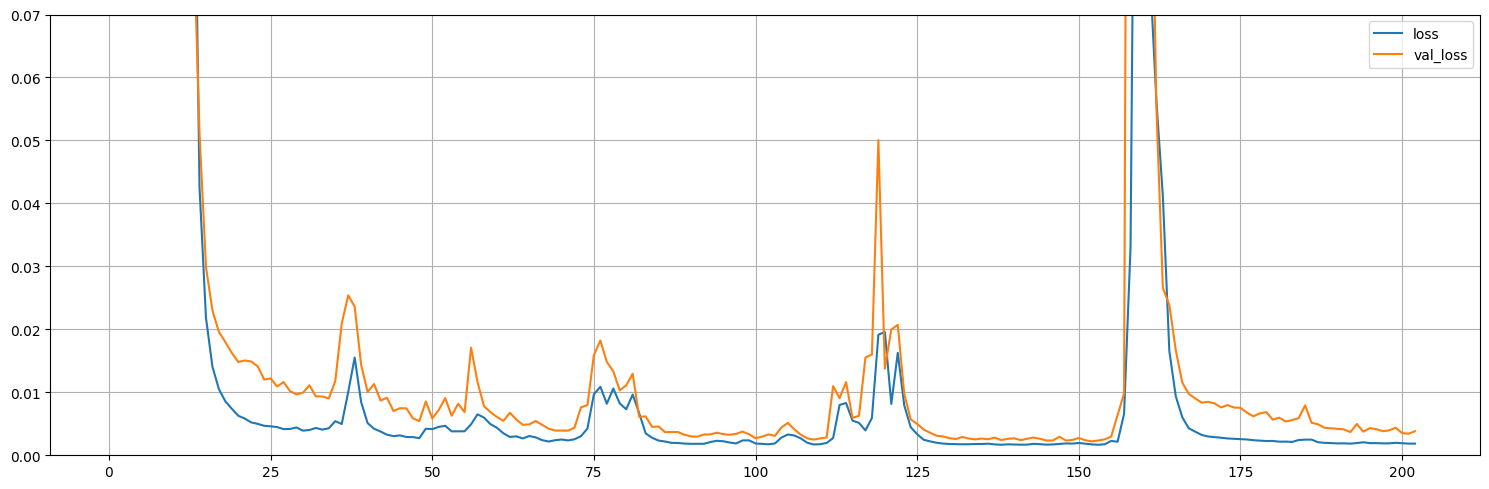

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0019 - val_loss: 0.0038


In [14]:
%load_ext tensorboard
import tensorflow as tf
from plot_learning import PlotLearning

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
 
log_dir = "logs/"

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=False, monitor="val_loss",
                                                  mode="min")
checkpoint_callback = ModelCheckpoint(filepath='weights/normalized3.weights.h5', save_best_only=True, monitor="val_loss",
                                      mode='min', save_weights_only=True)
# Create TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the model with TensorBoard logging     
autoencoder.fit(
    X_train, X_train,
    epochs=500 ,
    shuffle=True,

    batch_size=512,
    verbose=1,

    validation_split=0.2,
    callbacks=[tensorboard_callback, early_stopping, checkpoint_callback, PlotLearning(autoencoder)]
)

autoencoder.load_weights('weights/normalized3.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


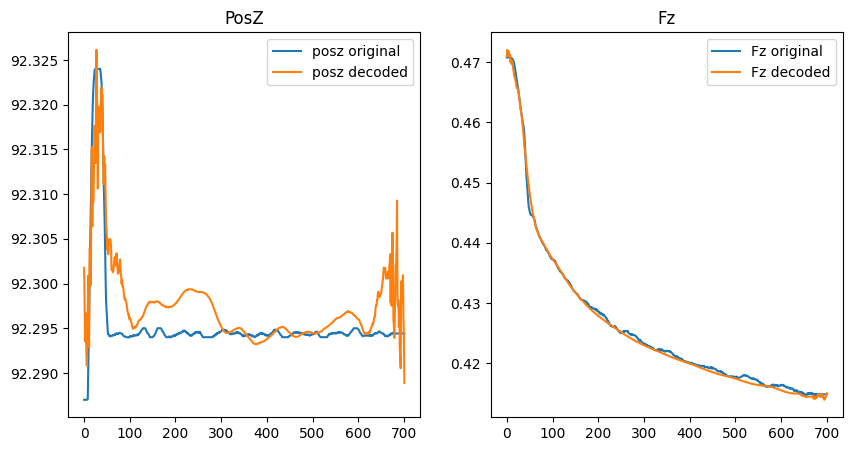

In [15]:
SIGNAL = 5

original = all_signals[SIGNAL]
sample_input = X_train[SIGNAL] 
sample_input = sample_input.reshape(1, 702, 2)
reconstructed_scaled = autoencoder.predict(sample_input)
reconstructed = reconstructed_scaled.reshape(-1, 2)
original_scale = scaler.inverse_transform(reconstructed)
decoded = original_scale.reshape(sample_input.shape)
decoded = decoded.reshape(702, 2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot the original signal
plt.subplot(1, 2, 1)
plt.title("PosZ")
plt.plot(original[:, 0], label='posz original')
plt.plot(decoded[:, 0], label='posz decoded')
plt.legend()

# Plot the decoded signal
plt.subplot(1, 2, 2)
plt.title("Fz")
plt.plot(original[:, 1], label='Fz original')
plt.plot(decoded[:, 1], label='Fz decoded')
plt.legend()

plt.show()


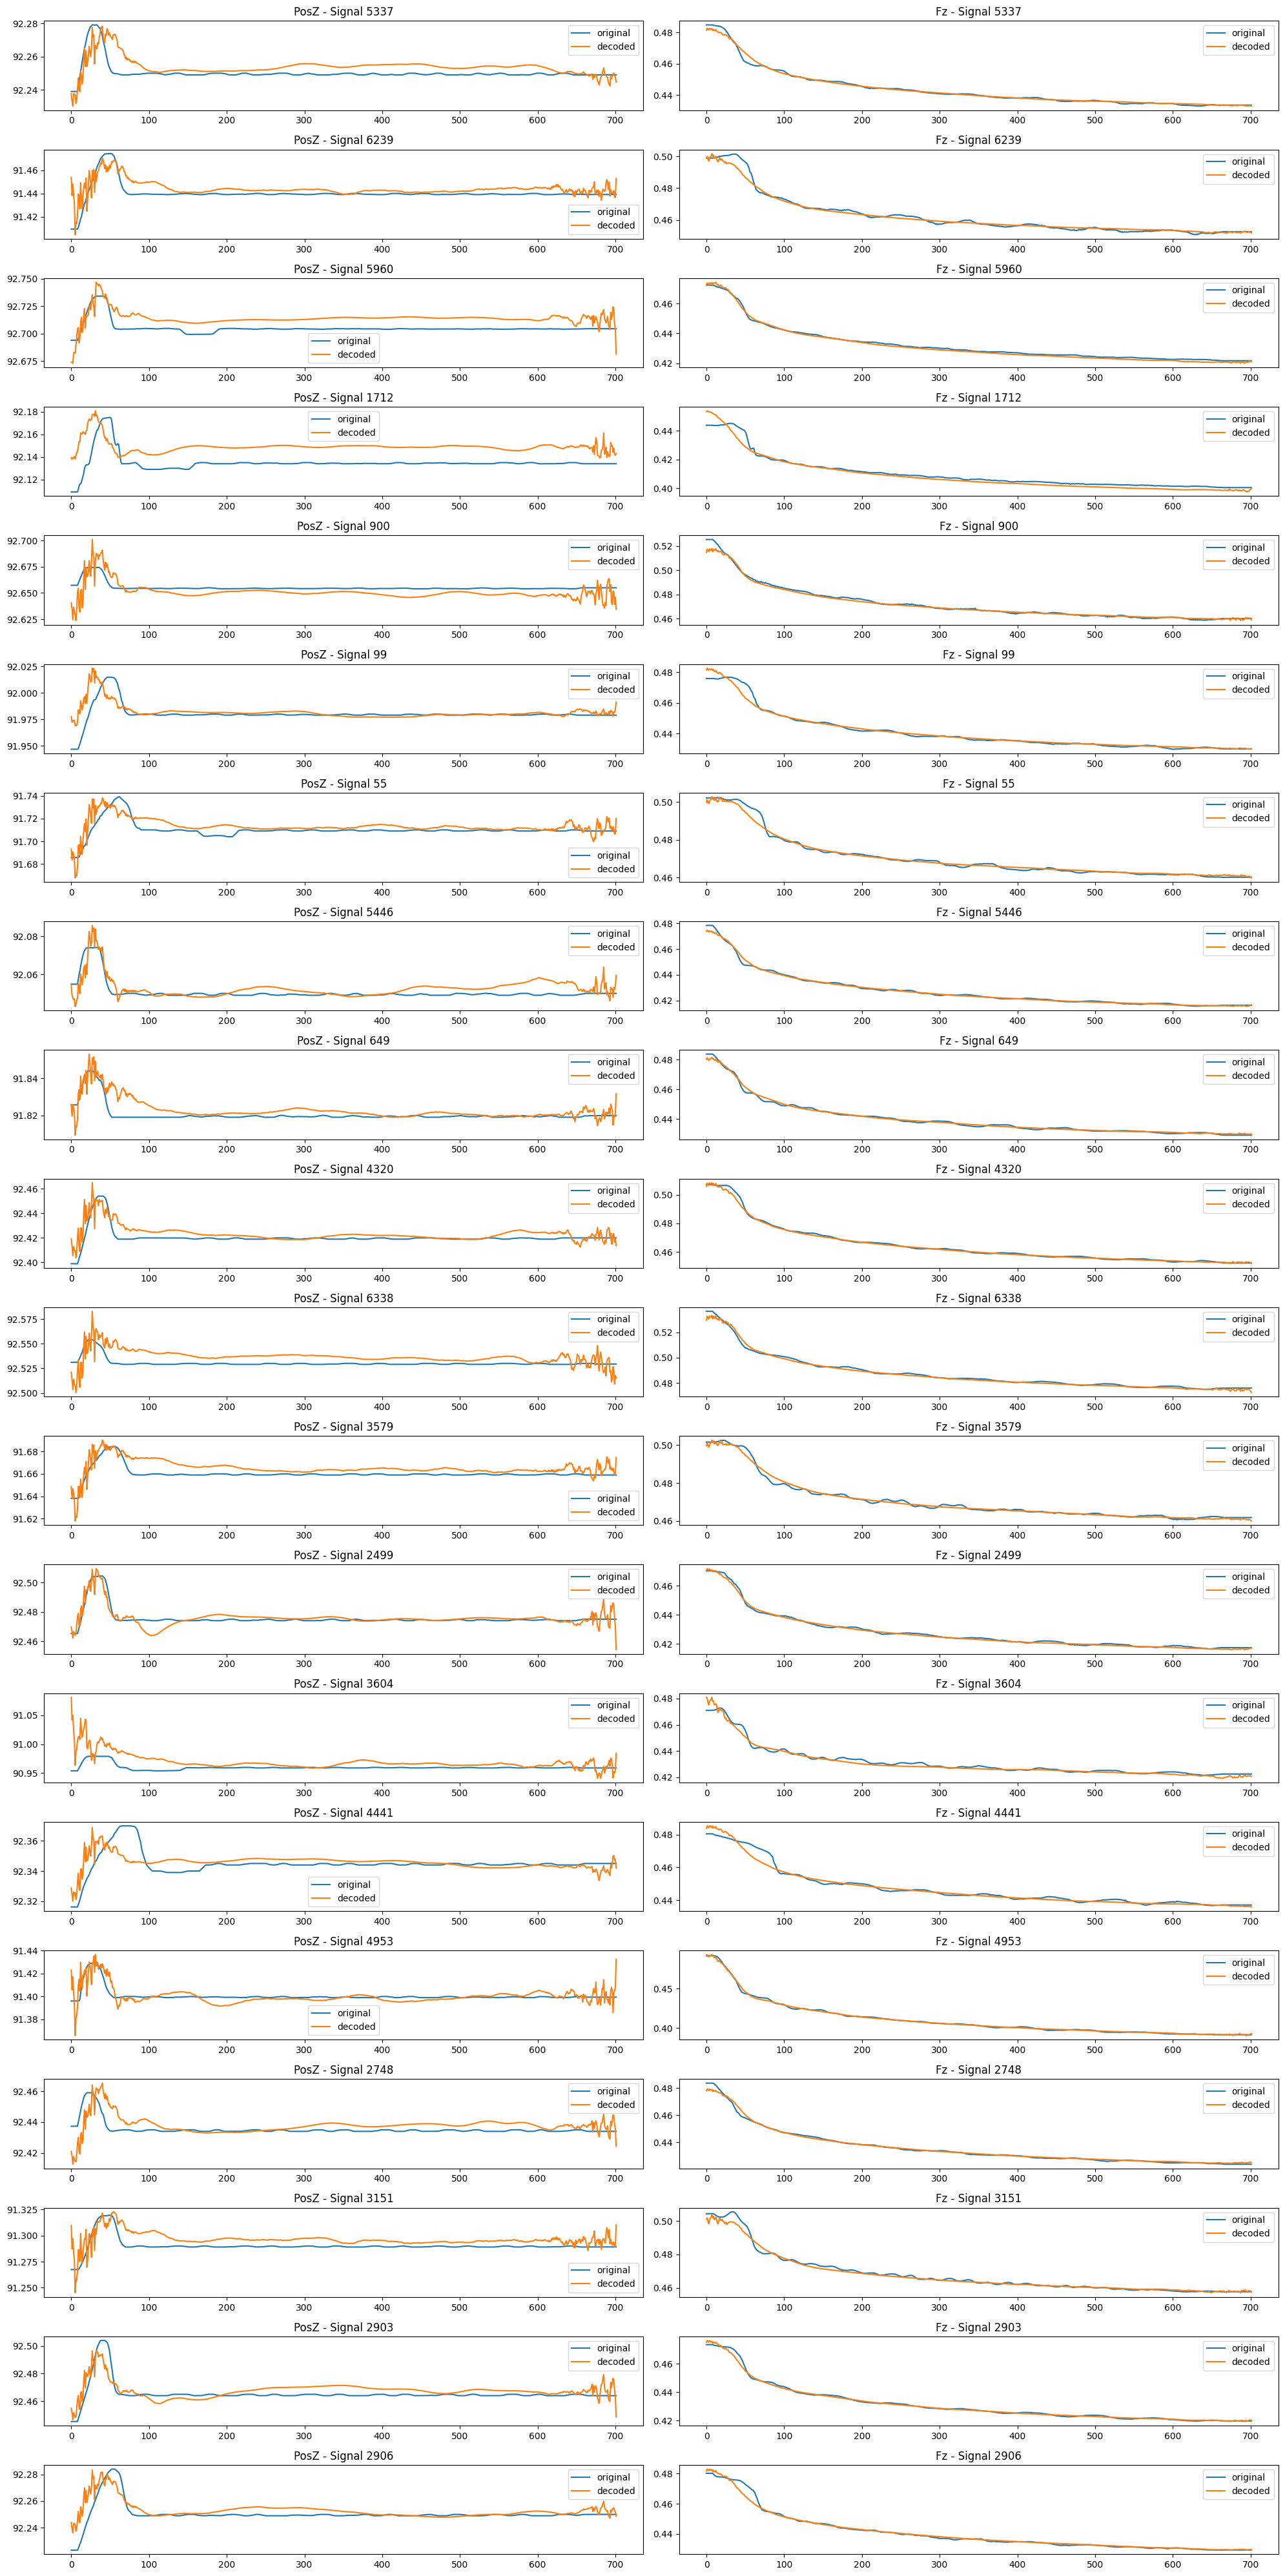

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Number of signals to display
NUM_SIGNALS = 20

# Get random indices
random_indices = random.sample(range(len(all_signals)), NUM_SIGNALS)

# Create a figure with appropriate size
plt.figure(figsize=(20, 40))

for i, idx in enumerate(random_indices):
    # Get original signal
    original = all_signals[idx]
    
    # Prepare input for autoencoder
    sample_input = X_train[idx]
    sample_input = sample_input.reshape(1, 702, 2)
    
    # Get reconstruction
    reconstructed_scaled = autoencoder.predict(sample_input, verbose = 0)
    reconstructed = reconstructed_scaled.reshape(-1, 2)
    original_scale = scaler.inverse_transform(reconstructed)
    decoded = original_scale.reshape(702, 2)
    
    # Plot PosZ
    plt.subplot(NUM_SIGNALS, 2, 2*i+1)
    plt.title(f"PosZ - Signal {idx}")
    plt.plot(original[:, 0], label='original')
    plt.plot(decoded[:, 0], label='decoded')
    plt.legend()
    
    # Plot Fz
    plt.subplot(NUM_SIGNALS, 2, 2*i+2)
    plt.title(f"Fz - Signal {idx}")
    plt.plot(original[:, 1], label='original')
    plt.plot(decoded[:, 1], label='decoded')
    plt.legend()

plt.tight_layout()
plt.show()